# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [4]:
# https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/VisualBanana_Linux.zip
env = UnityEnvironment(file_name="./VisualBanana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


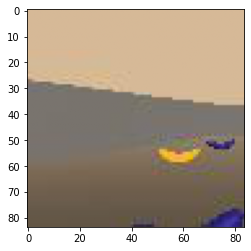

States have shape: (1, 84, 84, 3)


In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [10]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [12]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Pre-processing
For this specific task, we might not need to process RGB images, for example, in grey scale, the yellow and blue colors are pretty different, hence we might be okay if we simply get rid of the 3 color channel to make tensor operations easier. Furthermore, we could also exploit the fact that we are going to get rid of the color channel and encode time instead, to simulate movement. Although, for this particular task, encodign time or "movement" might not be necessary or even not be helpful at all since the only moving element in this task is the environment, the bananas are always static (except for the yellow ones when they spawn, they fall from above, although this should not affect that much the behaviour of the agent).

So, just for fun, I will implement both gray scale and a configurable framebuffer pre-processing so this can be used in other environments as well.

#### Grayscaling
One strategy is that we can just take the raw state from the environment and average the three color channels on every pixel such that we have only one value, the grayscale intensity.
Another strategy is to weight average the three channels, to give more importance to one color rather than others.

Original shape: (1, 84, 84, 3) New shape: (1, 84, 84)


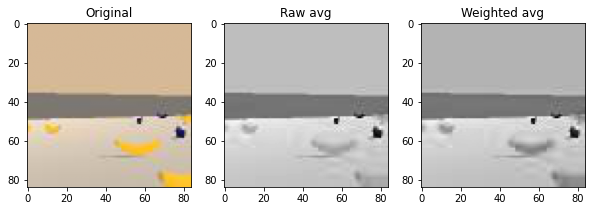

In [14]:
original_shape = state.shape
# option 1 raw average over the three color channels
grayed_state = np.mean(state, axis=3)
# option 2 weighted average over the three color channels
state2 = np.squeeze(state.copy())
# grayed_state_2 = state @ (0.114, 0.587, 0.299)
grayed_state_2 = state @ (0.1, 0.9, 0.7)
new_shape = grayed_state.shape
print(f"Original shape: {original_shape}", f"New shape: {new_shape}")

fig, axs = plt.subplots(1, 3, figsize=(10, 12))
axs[0].imshow(state.squeeze(0))
axs[0].set_title("Original")
axs[1].imshow(grayed_state.squeeze(0), cmap='gray')
axs[1].set_title("Raw avg")
axs[2].imshow(grayed_state_2.squeeze(0), cmap='gray')
axs[2].set_title("Weighted avg")
plt.show()

We can clearly see that in both cases we get an image of reduced dimension, and in the case of raw average, the yellow bananas are a little bit clearer. So I will stick with raw average.

#### Framebuffer
As mentioned earlier, the idea of the framebuffer is to encode timesteps or "movement" in the states, for some tasks this might be useful if the agent needs to keep track of the motion of an object in order to take actions. In this case however, it is not necessary because the objects (bananas) are always static. But only for fun, and because it might be useful in other kind of environments, I will implement it. So, the idea is simple. The environment will return a state for every action we take, the idea is to create a wrapper or decorator over the original environment and every step we submit to the environment we will deliver not only the returned state but also the last $n$ steps as a single state, i.e., we always keep track of the last $n$ steps and deliver those. For the initial case, we can just deliver blanks for the missing time steps, this won't be a problem when the agent starts playing and getting new timesteps.

In [16]:
import numpy as np
from collections import deque

class VizEnvDecorator:
    
    def __init__(self, env, brain_name: str, buffer_size: int = 4):
        self.env = env
        self.brain_name = brain_name
        self.buffer_size = buffer_size
        self.state = deque(maxlen=buffer_size)
        self.frame_action = deque(maxlen=buffer_size)
        
    def reset(self, train_mode: bool):
        self.state.clear()
        self.frame_action.clear()
        env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        frame = self.preprocess_frame(env_info.visual_observations[0])
        self.state.append(frame)
        self.frame_action.append(-1)
        return self.get_state()
    
    def step(self, action):
        env_info = self.env.step(action)[self.brain_name]
        frame = self.preprocess_frame(env_info.visual_observations[0])
        self.state.append(frame)
        self.frame_action.append(action)
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        return self.get_state(), reward, done
    
    def get_state(self):
        # fill the buffer with blanks if not full yet
        for _ in range(self.state.maxlen - len(self.state)):
            self.state.appendleft(np.zeros_like(self.state[0]))
            
        return np.concatenate(self.state)
            
    def get_frame_actions(self):
        # fill the buffer with blanks if not full yet
        for _ in range(self.frame_action.maxlen - len(self.frame_action)):
            self.frame_action.appendleft(-1)
            
        return self.frame_action

    def preprocess_frame(self, state):
        # return np.mean(state, axis=3)
        return state @ (0.1, 0.9, 0.7)
    
    
class EnvDecorator:
    def __init__(self, env, brain_name: str):
        self.env = env
        self.brain_name = brain_name
        
    def reset(self, train_mode: bool):
        env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        state = env_info.visual_observations[0]
        return state.transpose([0, 3, 1, 2])
    
    def step(self, action):
        env_info = self.env.step(action)[self.brain_name]
        next_state = env_info.visual_observations[0]
        next_state = next_state.transpose([0, 3, 1, 2])
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        return next_state, reward, done
    

Let's ensure we still can play the game normally using this decorator

In [18]:
env_dec = VizEnvDecorator(env, brain_name)
state = env_dec.reset(train_mode=False)
score = 0                                         
while True:
    action = np.random.randint(action_size)       
    next_state, reward, done = env_dec.step(action)
    score += reward                               
    state = next_state                            
    if done:                                      
        break
    
print("Score: {}".format(score))

Score: 1.0


In [20]:
env_dec_2 = EnvDecorator(env, brain_name)
state = env_dec.reset(train_mode=False)
score = 0                                         
while True:
    action = np.random.randint(action_size)       
    next_state, reward, done = env_dec.step(action)
    score += reward                               
    state = next_state                            
    if done:                                      
        break
    
print("Score: {}".format(score))

Score: 0.0


It works! let's explore the frames it outputs

In [22]:
frame_buffer = env_dec.get_state()
frame_actions = env_dec.get_frame_actions()
frame_buffer.shape

(4, 84, 84)

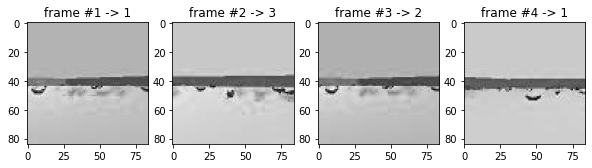

In [24]:
fig, axs = plt.subplots(1, frame_buffer.shape[0], figsize=(10, 12))
img = frame_buffer.transpose([1, 2, 0])
for i, ax in enumerate(axs):
    ax.imshow(img[:,:,i], cmap='gray')
    ax.set_title(f"frame #{i + 1} -> {frame_actions[i]}")
plt.show()

It works!, Naturally, with the frame buffer implementation, we can choose a single frame, which will be equivalent to only grayscale every frame and train on one frame at a time.

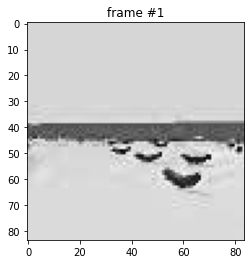

In [26]:
env_dec = VizEnvDecorator(env, brain_name, buffer_size=1)
state = env_dec.reset(train_mode=False)
img = state.transpose([1, 2, 0])
fig, axs = plt.subplots(1, state.shape[0])
axs = [axs]
for i, ax in enumerate(axs):
    ax.imshow(img[:,:,i], cmap='gray')
    ax.set_title(f"frame #{i + 1}")
plt.show()

Perfect! Now the rest of the notebook should be very similar to the original one except for the neural network which now we should add convolutions in order to extract visual features.

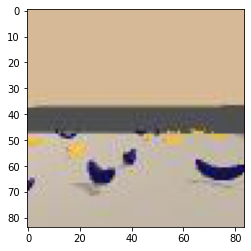

In [28]:
env_dec_2 = EnvDecorator(env, brain_name)
state = env_dec_2.reset(train_mode=False)
state = state.squeeze(0).transpose([1, 2, 0])
plt.imshow(state)
plt.show()

### Define Q-networks
Here we define a simple dense neural network as the function approximator. For this scenario, we don't require a complex architecture.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """QNetwork.
    
    Simple Dense neural network
    to serve as funcction approximator.
    """
    def __init__(
        self, 
        action_size, 
        seed, 
        in_channels=3,
        conv1_kernel=5,
        conv1_filters=32,
        conv1_strides=2,
        conv2_kernel=4,
        conv2_filters=64,
        conv2_strides=2,
        conv3_kernel=3,
        conv3_filters=64,
        conv3_strides=1,
        fc1_units=512, 
        fc2_units=512, 
        fc3_units=256
    ):
        super(QNetwork, self).__init__()
        self.seed = seed
        
        # self.network = nn.Sequential(
        #     nn.Conv2d(in_channels=in_channels, out_channels=conv1_filters, kernel_size=conv1_kernel, stride=conv1_strides, padding=0),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(32),
        #     nn.Conv2d(in_channels=conv1_filters, out_channels=conv2_filters, kernel_size=conv2_kernel, stride=conv2_strides, padding=0),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Conv2d(in_channels=conv2_filters, out_channels=conv3_filters, kernel_size=conv3_kernel, stride=conv3_strides, padding=0),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Flatten(),
        #     nn.Linear(in_features=conv3_filters * 17 * 17, out_features=fc1_units),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(fc1_units, fc2_units),
        #     nn.ReLU(),
        #     nn.Linear(fc2_units, fc3_units),
        #     nn.ReLU(),
        #     nn.Linear(fc3_units, action_size)
        # )
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features= 64 * 9 * 9, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=action_size)
        )
        
    def forward(self, x):
        return self.network(x)

### Define Memory buffer

As part of the DQN algorithm, we need to use the experience replay buffer. Hence the class below defines the minimal logic for a experience replay buffer.

In [32]:
from collections import namedtuple, deque
import random


class ReplayBuffer:
    """Replay buffer.
    
    This class implements a simple replay
    buffer of a fixed size and able to
    take random samples of a fixed size.
    """
    def __init__(self, buffer_size, batch_size, seed, device):
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.device = device
        
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Sample.
        
        Selects randomly a batch of sise batch_size
        from the current memory buffer. It delivers a
        tuple of (states, actions, next_states, dones)
        every element as a torch tensor.
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([np.expand_dims(e.state, axis=0) for e in experiences if e is not None])).float().to(self.device)
#         states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        n_states = torch.from_numpy(np.vstack([np.expand_dims(e.next_state, axis=0) for e in experiences if e is not None])).float().to(self.device)
#         n_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        
        return (states, actions, n_states, rewards, dones)
    
    def __len__(self):
        return len(self.memory)

### Define Q-Agent

This defines The DQN agent logic which is able to act (take action based on a provided state) and learn (perform a forward-backward pass on the QNetworks) as per DQN algorithm. This agent implements both classic DQN and Double DQN.

In [34]:
import torch.optim as optim

class Agent:
    
    def __init__(self, 
                 action_size, 
                 seed,
                 in_channels=4,
                 buffer_size=int(1e5), 
                 batch_size=64,
                 device='cpu',
                 lr=5e-4,
                 gamma=0.99,
                 tau=1e-3,
                 update_every=4,
                 update_target_every=1000,
                 use_double_q=False):
        """Agent.
        
        DQN/DDQN agent.
        """
        self.action_size = action_size
        self.seed = seed
        self.lr = lr
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.device = device
        self.update_every = update_every
        self.update_target_every = update_target_every
        self.gamma = gamma
        self.tau = tau
        self.use_double_q = use_double_q
        
        # Q-Network
        self.qnetwork_local = QNetwork(action_size, seed, in_channels=in_channels).to(self.device)
        self.qnetwork_target = QNetwork(action_size, seed, in_channels=in_channels).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)
        
        # Replay memory
        self.memory = ReplayBuffer(buffer_size, batch_size, seed, device)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        """step.
        
        (For training). This will add the current
        sars tuple in the buffer and it will perform a learning
        step over the QNetworks as per definition.
        """
        # save to experience buffer
        self.memory.add(state, action, reward, next_state, done)
        
        # update every n time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
                
    def learn(self, experiences):
        """learn.
        
        (For training). This will perform
        the actual learning steps over the QNetworks.
        """
        states, actions, next_states, rewards, dones = experiences
        
        # compute the targets as per formula
        Q_targets_next = self.qnetwork_target(next_states).detach()
        
        if self.use_double_q:
            Q_local_actions = self.qnetwork_local(next_states).detach().argmax(1)
            Q_targets_next = Q_targets_next.gather(1, Q_local_actions.unsqueeze(1))
            #Q_targets_next = Q_targets_next[Q_local_actions]
        else:
            Q_targets_next = Q_targets_next.max(1)[0].unsqueeze(1)
        
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        
        # compute expected Q values from the local Q network
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # backprop step
        self.optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 50)
        self.optimizer.step()
        
        # update the target network weights
        self.t_step = (self.t_step + 1) % self.update_target_every
        if self.t_step == 0:
            self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)
        
        
    def soft_update(self, local, target, tau):
        """soft update.
        
        The idea here is to update target weights slighlty in the direction
        of the local network. The tau parameter determines what proportion
        of each network to use. Small values of tau makes the target network
        weights more important than local.
        """
        for target_param, local_param in zip(target.parameters(), local.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)
            
    def act(self, state, eps=0.):
        """act.
        
        Selects an action depending on the provided state
        by doing a forward pass over the internal Q network.
        """
        state = np.expand_dims(state, axis=0)
#         state = state.squeeze(0)
        state = torch.from_numpy(state).float().to(self.device)
        self.qnetwork_local.eval()
        
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
            
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.randint(self.action_size)
            

### DQN Algorihm

This is the actual DQN algorithm routine. It will use the hyper-parameters to run training steps over a provided agent and environment. Hence, this algorithm is generic enough to support different tasks and agents, subject to their compatibility.

In [36]:
from tqdm import tqdm

def dqn(
    agent, 
    env,
    n_episodes=2000, 
    max_t=1000, 
    eps_start=1.0, 
    eps_end=0.01, 
    eps_decay=0.995,
    checkpoint_name='checkpoint.pth'):
    """dqn.
    
    DQN Algorithm.
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    with tqdm(total=n_episodes) as progress:
        for i_episode in range(1, n_episodes + 1):
            state = env.reset(train_mode=True)
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                next_state, reward, done = env.step(action)
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break

            eps = max(eps_end, eps * eps_decay)
            scores_window.append(score)
            scores.append(score)
            progress.set_postfix({"Avg. Score": f"{np.mean(scores_window):.2f}"})
            progress.update()

            if np.mean(scores_window) >= 13.0:
                print(f"Environment solved at {i_episode} episodes with Avg. score: {np.mean(scores_window):.2f}")
                torch.save(agent.qnetwork_local.state_dict(), checkpoint_name)
                break
    return scores

### Perform a training round using a vanilla DQN agent

In [38]:
%%time
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
in_channels = 4
buffer_size = int(1e4)

action_size = brain.vector_action_space_size
seed = 1234
device = "cuda" if torch.cuda.is_available() else "cpu"

env_dec = VizEnvDecorator(env, brain_name, buffer_size=in_channels)
# env_dec = EnvDecorator(env, brain_name)

agent = Agent(
    action_size, 
    seed,
    in_channels=in_channels,
    buffer_size=buffer_size, 
    batch_size=64, 
    tau=0.8, 
    lr=1e-4, 
    update_every=4,
    update_target_every=100,
    device=device)

scores = dqn(agent, env_dec, eps_start=0.5, n_episodes=200, checkpoint_name='rp_dqn_cp.pth')

100%|██████████| 200/200 [08:39<00:00,  2.60s/it, Avg. Score=0.04]

CPU times: user 34min 54s, sys: 10.7 s, total: 35min 5s
Wall time: 8min 42s


In [39]:
import matplotlib.pyplot as plt

def plot_scores(scores):
    """plot scores."""
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    x = np.arange(len(scores))
    y = scores
    
    plt.plot(x, y, label="avg. scores")
    
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.title("Agent progress over episodes")
    plt.show()

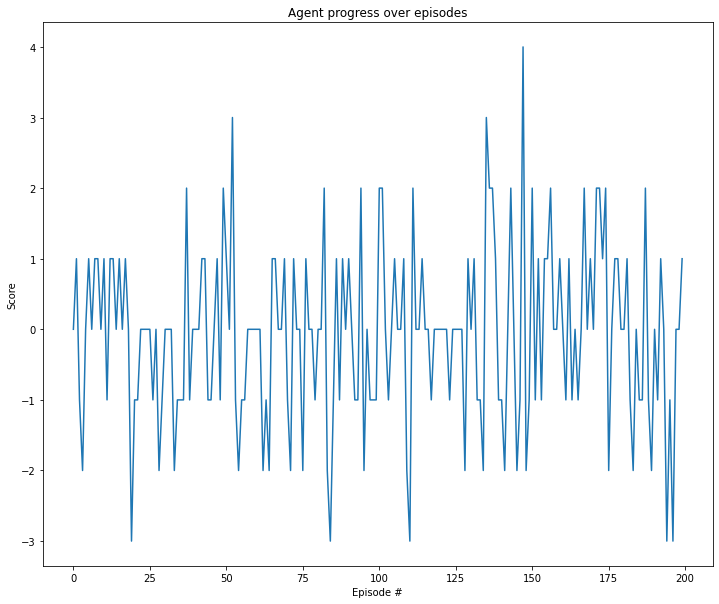

In [42]:
plot_scores(scores)

### Let's observe the agent playing

In [43]:
def play(agent, env, n_episodes=5, max_t=1000, eps=0.):
    """play.
    
    Uses the provided agent to play the game.
    There is no training in this code, only playing.
    """
    scores = []
    with tqdm(total=n_episodes) as progress:
        for i_episode in range(1, n_episodes + 1):
            env_info = env.reset(train_mode=False)
            state = env_info.vector_observations[0]
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                next_state, reward, done = env.step(action)
                state = next_state
                score += reward
                if done:
                    break

            scores.append(score)
            progress.set_postfix({"Avg. Score": f"{np.mean(scores):.2f}"})
            progress.update()

In [45]:
play(agent, env)

  0%|          | 0/5 [00:00<?, ?it/s]


AttributeError: 'dict' object has no attribute 'vector_observations'

In [ ]:
%%time
ddqn_agent = Agent(
    state_size, 
    action_size, 
    seed, 
    in_channels=in_channels
    buffer_size=buffer_size, 
    batch_size=64, 
    tau=5e-3, 
    lr=1e-3, 
    update_every=4,
    use_double_q=True,
    device=device)

ddqn_scores = dqn(ddqn_agent, env_dec, brain_name, n_episodes=2000, checkpoint_name='rp_ddqn_cp.pth')

In [ ]:
plot_scores(ddqn_scores)

## Compare DQN with DDQN

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


def smooth_values(x, smooth=10):
    x = np.asarray(x)
    y = np.ones(smooth)
    z = np.ones_like(x)
    return np.convolve(x, y, 'same') / np.convolve(z, y, 'same')

def plot_comparable_scores(
    data_list,
    min_len,
    smooth=10,
    colors = ["tab:red", "tab:blue"],
    labels = ["DQN", "DDQN"]):
    
    sns.set()
    
    fig = plt.figure(figsize=(12, 8))
    plt.clf()
    ax = fig.gca()
    
    color_patch = []
    for color, label, data in zip(colors, labels, data_list):
        smooth_data = smooth_values(data, smooth)
        #sns.lineplot(data=data, color=color, alpha=0.2, ci='sd')
        sns.lineplot(data=smooth_data, color=color, ci='sd')
        color_patch.append(mpatches.Patch(color=color, label=label))
        
    
    plt.xlim([0, min_len])
    plt.xlabel('Episode #', fontsize=22)
    plt.ylabel('Average score', fontsize=22)
    
    lgd=plt.legend(
        frameon=True, fancybox=True,
        prop={'weight':'bold', 'size':14}, handles=color_patch, loc="best"
    )
    
    plt.title('Progress comparison', fontsize=26)
    
    ax = plt.gca()

    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    sns.despine()
    plt.tight_layout()
    
    plt.show()

In [ ]:
data_list = [scores, ddqn_scores]
min_len = min(len(scores), len(ddqn_scores))
plot_comparable_scores(data_list, min_len, smooth=15)